# Team Mob Psycho

* Kanav Gupta
* Parth Partani 
* Anurag Mehta

# Relative Attributes using Rank SVM

### Import scipy libraries

In [1]:
import numpy as np
import scipy
import scipy.io as sio
from scipy.sparse import csr_matrix
from scipy.optimize import least_squares
import matplotlib.pyplot as plt 
import cv2
import gist
import matlab.engine
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import multivariate_normal
from numpy.linalg import inv, det
from sklearn.metrics import accuracy_score

* Compute the objective function, its gradient and the set of support vectors.
* Here all the comparisions are made for single attribute at a time.
* Also here out is maximum of 0 or (1 - A*X*W) where A is a sparse 2D matrix with rows denoting as pair for similar or open and each row has 2 elements as -1 and 1 at index i,j such that the comparision is made b/w image i and image j.
* A*X*W is a 1D matrix which contatins the difference of the attribute value of image i and j.

In [2]:
def object_fun_linear(w, C, out, n0, A, X):
    out[0:n0] = np.maximum(np.zeros([n0, 1]), out[0:n0])
    obj = np.sum(np.multiply(C, np.multiply(out, out))) / 2.0 + np.dot(np.transpose(w), w) / 2.0
    grad = w - np.transpose(np.transpose(np.multiply(C, out)) * A * X)
    sv = out[0:n0] > 0, abs(out[n0:]) > 0
    return obj[0, 0], grad, sv

* Here as we are using SVM so optimization is done with hessian matrix using Newton's method.
* This fxn computes the Hessian times a given vector x (support vectors calculated using object_fun_linear).

In [3]:
def hessian_mult(w, sv, C, grad, n0, A, X):
    w = np.transpose(np.matrix(w))
    y = w
    z = np.multiply(np.multiply(C, sv), A * (X * w))
    y += np.transpose(((np.transpose(z) * A) * X)) + grad
    y = y.A1
    return y

* Now we will find a line in the direction of d using our current 'w' matrix and then we will update 'w' using that solution.
* Here 1D Newton minimization is done.
* g = The gradient along the line.
* h = The second derivative along the line.
* Using g, h and taking newton step in that direction.

In [4]:
def line_search_linear(w, d, out, C, n0 ,A, X):
    t = 0
    Xd = A * (X * d)

    while 1:
        out2 = out - t * Xd
        sv = np.nonzero( scipy.vstack(( out2[0:n0] > 0, abs(out2[n0:]) > 0 )) )[0]
        g = np.transpose(w) * d + t * np.transpose(d) * d - np.transpose(np.multiply(C[sv], out2[sv])) * Xd[sv]
        h = np.transpose(d) * d + np.transpose(Xd[sv]) * np.multiply(Xd[sv], C[sv])
        g, h = g[0, 0], h[0, 0]
        t -= g / h
        if g * g / h < 1e-8: break
    out = out2
    return t, out

* X contains the training inputs / feature vectors and is an n x d matrix (n = number of images, d is dimensionality of each image i.e. features).
* O is a sparse p x n matrix, where p is the number of preference ordered pairs. Each row of O should contain exactly one +1 and one -1. If the Pth preference pair says i > j (strength of attribute in image i is greater than strength of attribute in image j) then O(p,i) = 1 and O(p,j) = -1
* S is a sparse p x n matrix, where p is the number of preference unordered pairs that have similar strengths of the attribute. Each row of S should contain exactly one +1 and one -1.
* C is a vector of training error penalizations (one for each preference pair).
* out = 1 - A*X*W
* Then finding support vectors usnig X, S, O, C, and then update w using the line found using 'line_search_linear' fxn.

In [5]:
def rank_svm(X_, S_, O_):
    max_itr, prec = 10, 1e-8

    X = X_; A = O_; B = S_;
    n0, d = A.shape[0], X.shape[1]
    w = scipy.matrix(scipy.zeros([d, 1]))

    itr = 0
    C = 0.1*scipy.ones([A.shape[0]+B.shape[0], 1])

    out1 = scipy.matrix(scipy.vstack( (scipy.ones([A.shape[0], 1]), scipy.zeros([B.shape[0], 1])) ))
    A = scipy.sparse.vstack((A, B))
    out = out1 - A * (X * w)
    
    while 1:
        itr += 1
        if itr > max_itr:
            print("Maximum number of Newton steps reached")
            break


        obj, grad, sv = object_fun_linear(w, C, out, n0, A, X)
        
        sv = scipy.vstack(sv)
        res = least_squares(hessian_mult, np.zeros(w.shape[0]), ftol = 1e-8, xtol = 1e-8, gtol = 1e-8, args = (sv, C, grad, n0, A, X))
        
        step = np.transpose(np.matrix(res.x))
        t, out = line_search_linear(w, step, out, C, n0, A, X)
        w += t * step;

        check = - np.transpose(step) * grad
        check = check[0, 0]
        print(check, prec*obj)
        if check < prec * obj: break

        print("Iteration = " + str(itr))
    print("Weight Matrix :")
    print(w)
    return w

* Loading data matrix containing class names, attribute names, images data(772 images reduced to 552 features), and relative ordering of images for given attributes.

In [6]:
datadict = sio.loadmat('pubfig_data.mat')

In [7]:
attr_names = []
for x in datadict['attribute_names'][0]:
    attr_names.append(x[0])
datadict['attribute_names'] = attr_names

datadict['im_names'] = datadict['im_names'][0]
datadict['class_labels'] = datadict['class_labels'][:, 0]
datadict['used_for_training'] = datadict['used_for_training'][:, 0]
datadict['class_names'] = datadict['class_names'][0]

* Iterating over images and classifying images into 2 sets S, O using relative ordering. 
* If 2 images are similar we add it to S else to O.
* Then we create sparse 2D matrix with S[i][j] = -1 and S[j][i] = 1 for any pair of images i,j if they are similar.
* Similarly applying this for O matrix.

## Attribute names

In [8]:
datadict['attribute_names']

[u'Male',
 u'White',
 u'Young',
 u'Smiling',
 u'Chubby',
 u'VisibleForehead',
 u'BushyEyebrows',
 u'NarrowEyes',
 u'PointyNose',
 u'BigLips',
 u'RoundFace']

In [9]:
p = 3 # Smiling attribute
cat_ordering = datadict['relative_ordering'][p]
train_data = datadict['used_for_training']
Sdata, Odata = [[],[],[]], [[],[],[]]
num = datadict['feat'].shape[0]
for i in range(len(datadict['class_labels'])):
    im1_lab = datadict['class_labels'][i] - 1
    for j in range(len(datadict['class_labels'][i+1:])):
        im2_lab = datadict['class_labels'][i+j+1] - 1
        if cat_ordering[im1_lab] == cat_ordering[im2_lab]:
            Sdata[0].append(len(Sdata[0])/2)
            Sdata[0].append(len(Sdata[0])/2)
            Sdata[1].append(i)
            Sdata[1].append(i+j+1)
            Sdata[2].append(-1)
            Sdata[2].append(1)

            Sdata[0].append(len(Sdata[0])/2)
            Sdata[0].append(len(Sdata[0])/2)
            Sdata[1].append(i)
            Sdata[1].append(i+j+1)
            Sdata[2].append(1)
            Sdata[2].append(-1)
        elif cat_ordering[im1_lab] < cat_ordering[im2_lab]:
            Odata[0].append(len(Odata[0])/2)
            Odata[0].append(len(Odata[0])/2)
            Odata[1].append(i)
            Odata[1].append(i+j+1)
            Odata[2].append(-1)
            Odata[2].append(1)
        elif cat_ordering[im1_lab] > cat_ordering[im2_lab]:
            Odata[0].append(len(Odata[0])/2)
            Odata[0].append(len(Odata[0])/2)
            Odata[1].append(i)
            Odata[1].append(i+j+1)
            Odata[2].append(1)
            Odata[2].append(-1)

S = csr_matrix((Sdata[2], (Sdata[0], Sdata[1])),(int(len(Sdata[0])/2), num))
O = csr_matrix((Odata[2], (Odata[0], Odata[1])),(int(len(Odata[0])/2), num))
X = scipy.matrix(datadict['feat'])

In [12]:
w = rank_svm(X, S, O)

(16083.55932244451, 0.00012105500000000008)
Iteration = 1
(109.17443290485438, 4.0085472341894906e-05)
Iteration = 2
(4.496626223657933, 3.9593788696738614e-05)
Iteration = 3
(0.007227479974569982, 3.9570104704042456e-05)
Iteration = 4
(7.731253452050482e-05, 3.957006962761128e-05)
Iteration = 5
(3.4828762809383554e-08, 3.9570069243116756e-05)
Weight Matrix :
[[-1.65568263e+00]
 [ 1.55294079e+00]
 [ 9.18758785e-01]
 [ 9.35873993e-01]
 [-1.41549364e+00]
 [ 5.12605417e-01]
 [ 5.27458660e-01]
 [-9.83603572e-01]
 [ 4.17430773e-01]
 [-1.32242302e+00]
 [-1.26517181e+00]
 [-1.79719746e+00]
 [ 1.59852559e+00]
 [ 2.86953741e-02]
 [-3.82585467e-01]
 [ 3.17886743e-01]
 [ 1.06272688e+00]
 [ 1.75852825e+00]
 [ 4.50219820e-01]
 [ 1.78798163e+00]
 [-4.34159400e-01]
 [ 2.18598137e+00]
 [-1.16673317e+00]
 [-5.70132591e-01]
 [-5.86080444e-01]
 [ 4.63066567e-02]
 [-4.69768798e-01]
 [-2.35141568e+00]
 [ 1.37783909e+00]
 [-1.78576230e+00]
 [ 3.06547103e-01]
 [-1.21492575e+00]
 [ 3.65101180e-01]
 [-4.454564

### Checking Accuracy for all 11 Attributes

In [10]:
def checkAccuracy(w,p):
    cat_ordering = datadict['relative_ordering'][p]
    train_data = datadict['used_for_training']
    num = datadict['feat'].shape[0]
    X = datadict['feat']
    tot = 0
    corr = 0
    for i in range(len(datadict['class_labels'])):
        if train_data[i] == 0:
            continue
        im1_lab = datadict['class_labels'][i] - 1
        for j in range(len(datadict['class_labels'][i+1:])):
            if train_data[j] == 0:
                continue
            tot=tot+1    
            im2_lab = datadict['class_labels'][i+j+1] - 1
            val1 = np.dot(X[i],w[p])
            val2 = np.dot(X[j],w[p])
            if abs(val1-val2) < 0.001 and cat_ordering[im1_lab] == cat_ordering[im2_lab]:
                corr+=1
            elif val1 < val2 and cat_ordering[im1_lab] < cat_ordering[im2_lab]:
                corr+=1
            elif val1 > val2 and cat_ordering[im1_lab] > cat_ordering[im2_lab]:
                corr+=1
    acc = float(corr)/float(tot)
    print("Accuracy for Attribute "+str(p)+" = " + str(acc) + ","+str(corr) + "," + str(tot))

### Loading saved trained weights from RankSVM

In [11]:
attrs = np.load("attribs.npy")

In [12]:
for i in range(11):
    checkAccuracy(attrs,i)

Accuracy for Attribute 0 = 0.617198193266,18037,29224
Accuracy for Attribute 1 = 0.596838215166,17442,29224
Accuracy for Attribute 2 = 0.57267998905,16736,29224
Accuracy for Attribute 3 = 0.547905830824,16012,29224
Accuracy for Attribute 4 = 0.590644675609,17261,29224
Accuracy for Attribute 5 = 0.525082124281,15345,29224
Accuracy for Attribute 6 = 0.63543662743,18570,29224
Accuracy for Attribute 7 = 0.551875171092,16128,29224
Accuracy for Attribute 8 = 0.602655351766,17612,29224
Accuracy for Attribute 9 = 0.626984670134,18323,29224
Accuracy for Attribute 10 = 0.656241445387,19178,29224


## Comparision for Smiling Attribute

In [13]:
def compare(im1,im2,attr):
    im_names = datadict['im_names'].tolist()
    im1_idx = im_names.index(im1)
    im2_idx = im_names.index(im2)
    print("Attrbute values for image 1 and 2 : ")
    attr_names = datadict['attribute_names']
    atr_id = attr_names.index(attr)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.axis('off')
    im11 = cv2.cvtColor(cv2.imread('images/'+im1),cv2.COLOR_BGR2RGB)
    im12 = cv2.cvtColor(cv2.imread('images/'+im2),cv2.COLOR_BGR2RGB)
    plt.imshow(im11)
    plt.title("Value ="  + str(np.dot(X[im1_idx-1],attrs[atr_id])))
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(im12)
    plt.title("Value ="  + str(np.dot(X[im2_idx-1],attrs[atr_id])))
    plt.show()

Attrbute values for image 1 and 2 : 


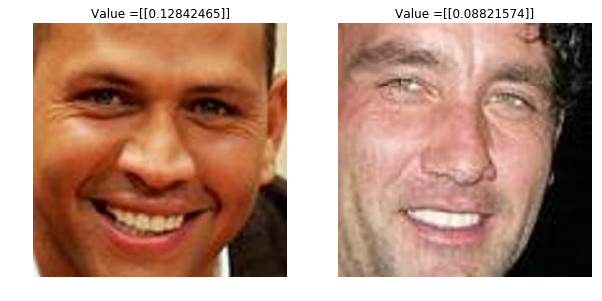

In [14]:
compare('AlexRodriguez_72.jpg','CliveOwen_170.jpg','Smiling')

Attrbute values for image 1 and 2 : 


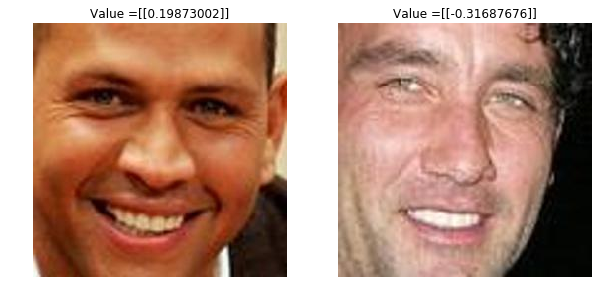

In [15]:
compare('AlexRodriguez_72.jpg','CliveOwen_170.jpg','Young')

Attrbute values for image 1 and 2 : 


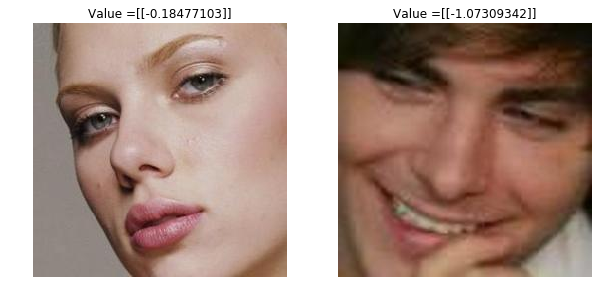

In [16]:
compare('ScarlettJohansson_14.jpg','ZacEfron_388.jpg','BigLips')

Attrbute values for image 1 and 2 : 


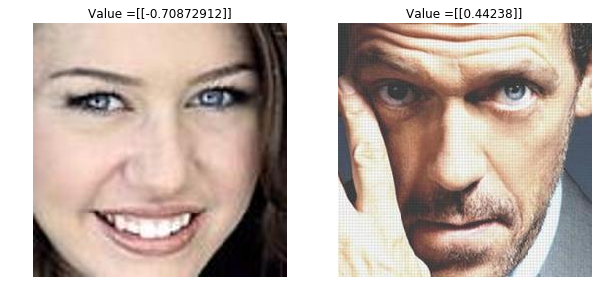

In [17]:
compare('MileyCyrus_89.jpg','HughLaurie_75.jpg','NarrowEyes')

Attrbute values for image 1 and 2 : 


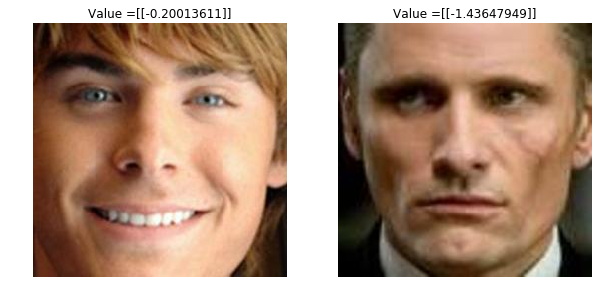

In [18]:
compare('ZacEfron_285.jpg','ViggoMortensen_68.jpg','Chubby')

## Extract Feature

Creates feature vector for the image provided. Image vector is created by appening histogram features to GIST features.
MATLAB Implemention from GIST research paper is taken for calculating GIST features.

In [19]:
def ExtractFeats(img_path):
    eng = matlab.engine.start_matlab()
    gist_feat = eng.extract_gist(img_path);
    return np.array(gist_feat)

In [20]:
feat1 = ExtractFeats("images/Anoop1s.jpg")

* Now finding predictions for all attributes

In [21]:
allpreds = []
nmes = datadict['im_names'].tolist()
k = 0
for feat in X:
    reply = []
    for w in attrs:
        xx = float(np.dot(feat,w))
        reply.append(xx)
    reply.append(str(nmes[k][0]))
    k+=1
    allpreds.append(reply)

## Textual Image Description Generator

Takes and image and find two images, one with higher score and other one with lower score. Both images are chosen such that they are not soo close that they cant be distinguished properly and not too far as it will become trivial.

In [22]:
def describe(img_path,p,fl):
    if fl:
        im_names = datadict['im_names'].tolist()
        im1_idx = im_names.index(img_path)
        feats = X[im1_idx-1]
    else:
        feats = ExtractFeats(img_path)
    val = np.dot(feats,attrs[p])
    srt = sorted(allpreds,key=lambda x: x[p])
    for i in range(772):
        if srt[i][p] > val:
            k = i + 150
            if k >= 772:
                k = 771
            j = i - 150
            if j < 0:
                j = 0
            
            im11 = cv2.cvtColor(cv2.imread('images/'+srt[k][11]),cv2.COLOR_BGR2RGB)
            im12 = cv2.cvtColor(cv2.imread('images/'+srt[j][11]),cv2.COLOR_BGR2RGB)
            if fl:
                im13 = cv2.cvtColor(cv2.imread("images/" + img_path),cv2.COLOR_BGR2RGB)
            else:
                im13 = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15,15))
            plt.subplot(131)
            plt.axis('off')
            plt.imshow(im12)
            plt.title("Value ="  + str(srt[j][p]))
            plt.subplot(132)
            plt.axis('off')
            plt.imshow(im13)
            plt.title("Value ="  + str(val))
            plt.subplot(133)
            plt.axis('off')
            plt.imshow(im11)
            plt.title("Value ="  + str(srt[k][p]))
            plt.show()
            print "Image is more " + datadict['attribute_names'][p] + " than " + srt[k][11] + " and less " + datadict['attribute_names'][p] + " than " + srt[j][11]
            return val

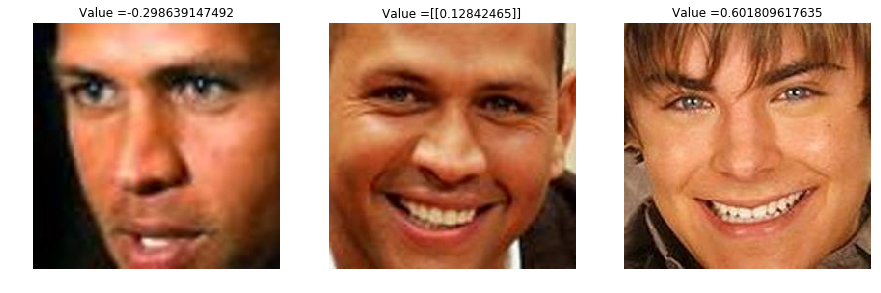

Image is more Smiling than ZacEfron_252.jpg and less Smiling than AlexRodriguez_139.jpg


matrix([[0.12842465]])

In [23]:
describe("AlexRodriguez_72.jpg",3,1)

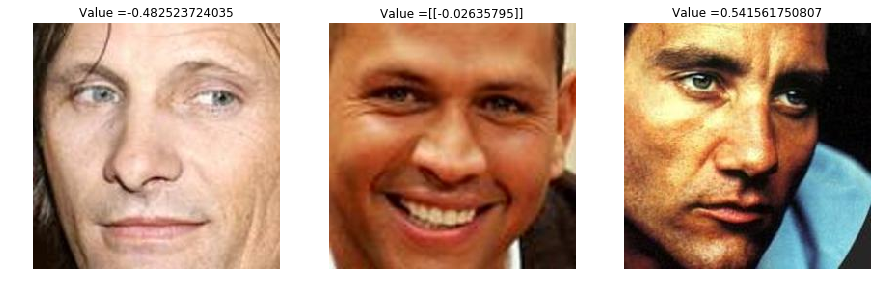

Image is more Male than CliveOwen_119.jpg and less Male than ViggoMortensen_146.jpg


matrix([[-0.02635795]])

In [24]:
describe("AlexRodriguez_72.jpg",0,1)

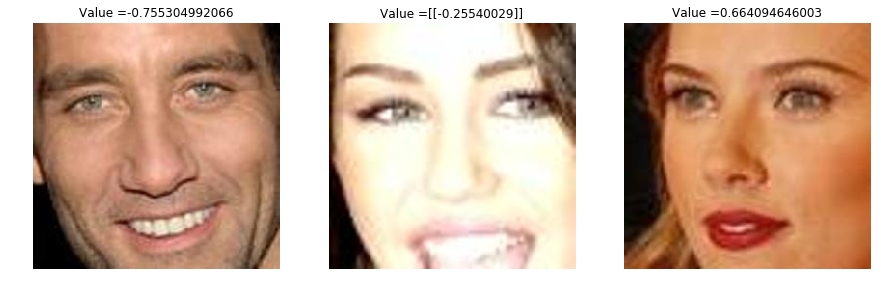

Image is more BigLips than ScarlettJohansson_100.jpg and less BigLips than CliveOwen_89.jpg


matrix([[-0.25540029]])

In [25]:
describe("MileyCyrus_1135.jpg",9,1)

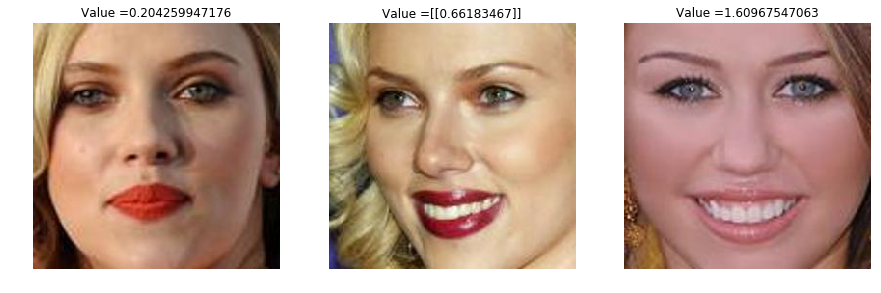

Image is more Smiling than MileyCyrus_66.jpg and less Smiling than ScarlettJohansson_176.jpg


matrix([[0.66183467]])

In [26]:
describe("ScarlettJohansson_107.jpg",3,1)

# Zero Shot Learning

* Loading trained weights for seen classes only

In [27]:
seen = [1, 2, 3, 4]
unseen = [5,6,7,8]

* Training RankSVM only for seen classes

In [ ]:
zero_weights = np.zeros((11,542))
train_data = datadict['used_for_training']
for p in range(len(datadict['attribute_names'])):
    # p = 1 # Smiling attribute
    cat_ordering = datadict['relative_ordering'][p]
    train_data = datadict['used_for_training']
    Sdata, Odata = [[],[],[]], [[],[],[]]
    num = datadict['feat'].shape[0]
    for i in range(len(datadict['class_labels'])):
        if datadict['class_labels'][i] not in seen:
            continue
        im1_lab = datadict['class_labels'][i] - 1
        for j in range(len(datadict['class_labels'][i+1:])):
            if datadict['class_labels'][i+j+1] not in seen:
                continue
            im2_lab = datadict['class_labels'][i+j+1] - 1
            if cat_ordering[im1_lab] == cat_ordering[im2_lab]:
                Sdata[0].append(len(Sdata[0])/2)
                Sdata[0].append(len(Sdata[0])/2)
                Sdata[1].append(i)
                Sdata[1].append(i+j+1)
                Sdata[2].append(-1)
                Sdata[2].append(1)

                Sdata[0].append(len(Sdata[0])/2)
                Sdata[0].append(len(Sdata[0])/2)
                Sdata[1].append(i)
                Sdata[1].append(i+j+1)
                Sdata[2].append(1)
                Sdata[2].append(-1)
            elif cat_ordering[im1_lab] < cat_ordering[im2_lab]:
                Odata[0].append(len(Odata[0])/2)
                Odata[0].append(len(Odata[0])/2)
                Odata[1].append(i)
                Odata[1].append(i+j+1)
                Odata[2].append(-1)
                Odata[2].append(1)
            elif cat_ordering[im1_lab] > cat_ordering[im2_lab]:
                Odata[0].append(len(Odata[0])/2)
                Odata[0].append(len(Odata[0])/2)
                Odata[1].append(i)
                Odata[1].append(i+j+1)
                Odata[2].append(1)
                Odata[2].append(-1)

    S = csr_matrix((Sdata[2], (Sdata[0], Sdata[1])),(int(len(Sdata[0])/2), num))
    O = csr_matrix((Odata[2], (Odata[0], Odata[1])),(int(len(Odata[0])/2), num))
    X = scipy.matrix(datadict['feat'])
    w = rank_svm(X, S, O)
    zero_weights[p] = np.squeeze(w,axis=1)
np.save('attribs1.npy',zero_weights)

In [28]:
attrs1 = np.load("attribs1.npy")
attrs1.shape

(11, 542)

In [29]:
datadict['relative_ordering']

array([[6, 8, 7, 5, 2, 1, 4, 3],
       [1, 2, 3, 5, 7, 6, 8, 4],
       [5, 3, 2, 4, 8, 6, 1, 7],
       [4, 4, 3, 1, 6, 5, 2, 5],
       [8, 4, 3, 2, 6, 7, 1, 5],
       [5, 5, 5, 1, 3, 4, 5, 2],
       [6, 7, 5, 8, 1, 2, 4, 3],
       [4, 6, 5, 2, 1, 3, 7, 8],
       [1, 2, 8, 3, 3, 4, 3, 7],
       [7, 5, 1, 2, 6, 8, 3, 4],
       [6, 4, 1, 3, 8, 7, 2, 5]], dtype=uint8)

### Setting params [l,r] for each attribute in unseen classes using relative ordering 

In [30]:
relative_input = {
    # 5
    5 : [
        [-1, 4], #1
        [4, -1], #2
        [-1, 3], #3
        [4, 3], #4
        [-1, 4], #5
        [4, -1], #6
        [-1, 3], #7
        [2, -1], #8
        [2, 3], #9
        [4, 2], #10
        [3, 4] #11
    ],
        # 5
    6 : [
        [-1, 1], #1
        [1, -1], #2
        [3,-1], #3
        [2,-1], #4
        [2,1], #5
        [4,1], #6
        [-1,3], #7
        [4,2], #8
        [1,3], #9
        [3,-1], #10
        [3,-1] #11
    ],
    # 7
    7 : [
        [-1, 4], #1
        [4, -1], #2
        [-1, 3], #3
        [4, 3], #4
        [-1, 4], #5
        [4, -1], #6
        [-1, 3], #7
        [2, -1], #8
        [2, 3], #9
        [4, 2], #10
        [3, 4] #11
    ],
    # 8
    8 : [
        [-1, 4], #1
        [3, 4], #2
        [1, -1], #3
        [1, -1], #4
        [2, 1], #5
        [4, 3], #6
        [-1, 3], #7
        [2, -1], #8
        [4, 3], #9
        [4, 2], #10
        [2, 1] #11
    ]
}

* Predictions for images available in seen or unseen classes

In [31]:
allpreds1 = np.zeros((772, 11))
X = np.matrix(datadict['feat'])

for i,feat in enumerate(X):
    if datadict['class_labels'][i] in seen or datadict['class_labels'][i] in unseen:
        reply = []
        for w in attrs1:
            xx = float(np.dot(feat,w))
            reply.append(xx)
        allpreds1[i] = reply

In [32]:
mean_dict = {}
covariance_dict = {}

means = []
covariances = []

# GMM
* Creating generative model and training on data for seen classes.
* Now we will use Mean, Covariance from the model to predict attributes for unseen classes.

In [33]:
for s_cat in seen:
    data = allpreds1[datadict['class_labels'] == s_cat, :]
    gmm = GMM()
    gmm.fit(data)
    mean_dict[s_cat] = gmm.means_[0]
    covariance_dict[s_cat] = gmm.covariances_[0]
    means.append(gmm.means_[0].tolist())
    covariances.append(gmm.covariances_[0].tolist())

* Here we will use [l, r] pairs to predict the attribute value.
* If its left and right are positive integers, its mean will be average of the 2.
* If it leftmost then we will move towards right by subtracting "dms" which average distance mean of 2 classes.
* Similarly if it is rightmost, we will move away from it by adding dms to it.

In [34]:
num_attr = 11
means = np.array(means)
means = np.sort(means, axis = 0)
X_attr = allpreds1
dms = (means[len(seen)-1, :] - means[0, :])/len(seen)

covariances = np.array(covariances)
mean_covars = np.mean(covariances, axis = 0)

for unseen_cat in unseen:
    new_mean = np.zeros((num_attr,))
    new_covar = mean_covars

    for attr in range(num_attr):
        l, r = relative_input[unseen_cat][attr]

        if l == -1 and r == -1:
            new_mean[attr] = np.mean(means[:,attr])
        elif l == -1:
            new_mean[attr] = mean_dict[r][attr] - dms[attr]
#             print(mean_dict[r][attr], dms[attr], new_mean[attr])
        elif r == -1:
            new_mean[attr] = mean_dict[l][attr] + dms[attr]
        else:
            new_mean[attr] = (mean_dict[l][attr] + mean_dict[r][attr]) / 2.0

    mean_dict[unseen_cat] = new_mean
    print("New Mean : " + str(new_mean))
    covariance_dict[unseen_cat] = new_covar

all_cat = seen + unseen

test_X_attr = X_attr [ [idx for idx in range(len(datadict['class_labels'])) if datadict['class_labels'][idx] in all_cat], : ]
test_Y = []
for lab in (datadict['class_labels']):
    if lab in all_cat: test_Y.append(lab)

score_predictions = np.zeros((len(all_cat), test_X_attr.shape[0]))

for idx, cat in enumerate(all_cat):
    score_predictions[idx, :] = multivariate_normal.pdf(test_X_attr, mean = mean_dict[cat], cov = covariance_dict[cat])

pred = score_predictions.argmax(axis = 0)
pred = np.array(all_cat)[pred]
print(pred.shape)
print("Accuracy for Zero shot learning = " + str(accuracy_score(test_Y, pred)))

New Mean : [-1.80930666  1.95936721 -1.47511127 -1.2281509  -1.95936721 -0.74496366
 -1.47539581  0.61175739  0.91509697 -0.63359038 -1.17195399]
New Mean : [-1.18856074  0.17770857 -0.6649384   0.12428111 -0.0364083  -0.52262531
 -1.47539581 -0.59877464  0.62370243 -1.03858151 -1.03858151]
New Mean : [-1.80930666  1.95936721 -1.47511127 -1.2281509  -1.95936721 -0.74496366
 -1.47539581  0.61175739  0.91509697 -0.63359038 -1.17195399]
New Mean : [-1.80930666  1.18792887  0.95540733  0.14659986 -0.0364083  -0.52549265
 -1.47539581  0.61175739  1.17195399 -0.63359038 -0.08533882]
(772,)
Accuracy for Zero shot learning = 0.4948186528497409


### Here is the plot for accuracies v/s increasing proportion of unseen classes.

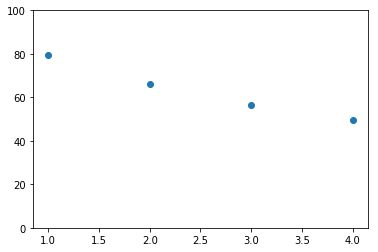

In [35]:
plt.ylim(0,100)
plt.plot([1,2,3,4],[79.58333333333333,66.20450606585788,56.59259259259259,49.48186528497409],'o')
plt.show()